In [1]:
!git clone https://github.com/Arminkhayati/CovidCT_CNN-


Cloning into 'CovidCT_CNN-'...
remote: Enumerating objects: 2488, done.
remote: Total 2488 (delta 0), reused 0 (delta 0), pack-reused 2488
Receiving objects: 100% (2488/2488), 229.89 MiB | 29.17 MiB/s, done.
Checking out files: 100% (2481/2481), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initializing

In [3]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
import cv2
import time
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
import cv2
import os
import math
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Softmax, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB7, ResNet50
import tensorflow as tf

In [13]:
def plot_results(one_hot_labels, labels, predicted_class_indices, pred):
  # Confusio Matrix

  sns.heatmap(confusion_matrix(labels, predicted_class_indices), 
              annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)


  # Roc curve and Average precision recall
  sick_vec = labels>0
  sick_score = np.sum(pred[:,1:],1)
  fpr, tpr, _ = roc_curve(sick_vec, sick_score)
  fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
  ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
  ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
  ax1.legend()
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')

  n_classes=2
  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  level_cat = one_hot_labels
  # level_cat = np.array([l.flatten() for l in level_cat])
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(level_cat[:, i],
                                                          pred[:, i])
      average_precision[i] = average_precision_score(level_cat[:, i], pred[:, i])

  precision["micro"], recall["micro"], _ = precision_recall_curve(level_cat.ravel(),
      pred.ravel())
  average_precision["micro"] = average_precision_score(level_cat, pred,
                                                      average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}\n\n\n\n\n'
        .format(average_precision["micro"]))


  plt.figure()
  plt.step(recall['micro'], precision['micro'], where='post')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
      'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
      .format(average_precision["micro"]))


  # Multi class precision recall
  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

  plt.figure(figsize=(7, 8))
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines = []
  labels = []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
      plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

  lines.append(l)
  labels.append('iso-f1 curves')
  l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
  lines.append(l)
  labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision["micro"]))

  for i, color in zip(range(n_classes), colors):
      l, = plt.plot(recall[i], precision[i], color=color, lw=2)
      lines.append(l)
      labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Extension of Precision-Recall curve to multi-class')
  plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(level_cat[:, i], pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(level_cat.ravel(), pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  lw = 2
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Multi class ROC curves
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()


In [9]:
# params
latent_size = 512
image_size = 256
num_labels = 2
channels = 3
batch_size = 16
train_steps = 3000
save_interval = 500
lr = 0.0002
beta = 0.5
decay = 6e-8
loss = ['binary_crossentropy', 'sparse_categorical_crossentropy']
epochs = 2000

In [7]:
!ls "/content/drive/My Drive/nn-prject"

generator = load_model("/content/drive/My Drive/nn-prject/ACGAN1.h5")
classifier1 = load_model("/content/drive/My Drive/nn-prject/new_good_resnet50.h5")
classifier2 = load_model("/content/drive/My Drive/nn-prject/new_77-80_resnet50.h5")


ACGAN1.h5  new_77-80_resnet50.h5			new_good_resnet50.h5
ACGAN.h5   new_best_on_gan_bad_on_original_resnet50.h5	resnet50-3-dense.h5


# Classifier Metrics on Original Dataset

Found 1999 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


(256, 256, 3)

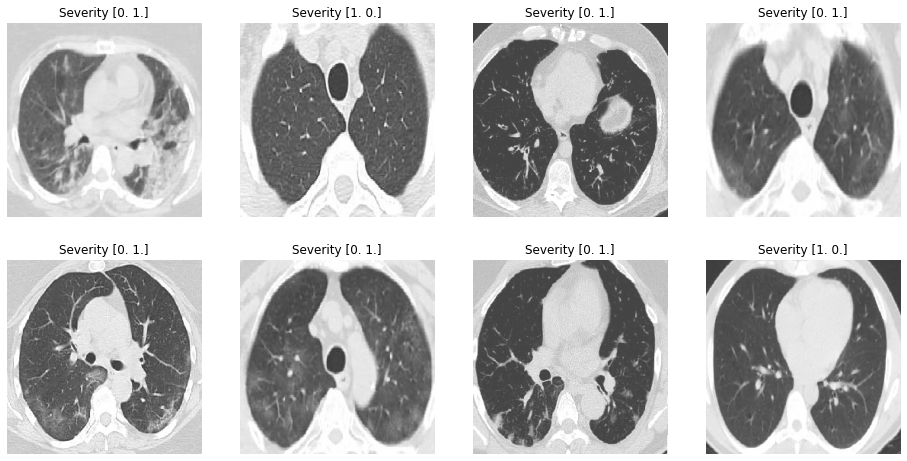

In [5]:
# https://keras.io/api/preprocessing/image/#flowfromdirectory-method



train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)





train_data = train_datagen.flow_from_directory(
        '/content/CovidCT_CNN-/data/train',
        target_size=(256, 256),
        color_mode="rgb",
        class_mode="categorical",
        shuffle=True,    
        batch_size=batch_size
)

test_data = train_datagen.flow_from_directory(
        '/content/CovidCT_CNN-/data/test',
        target_size=(256, 256),
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False,
        batch_size=batch_size
)




t_x, t_y = train_data.__getitem__(0)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
      c_ax.imshow(np.clip(c_x * 255, 0, 255).astype('int'))
      c_ax.set_title('Severity {}'.format(c_y))
      c_ax.axis('off')

t_x.shape[1:]

In [14]:
pred= classifier1.predict(test_data, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = test_data.classes[0:len(predicted_class_indices)]
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))

31/31 [==============================] - 4s 145ms/step
Accuracy on Test Data: 0.86%
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       230
           1       0.98      0.75      0.85       252

    accuracy                           0.86       482
   macro avg       0.88      0.86      0.86       482
weighted avg       0.88      0.86      0.86       482



Average precision score, micro-averaged over all classes: 0.92







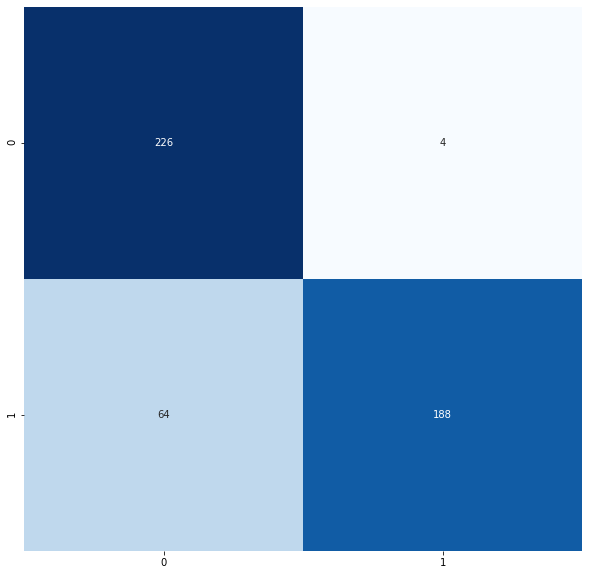

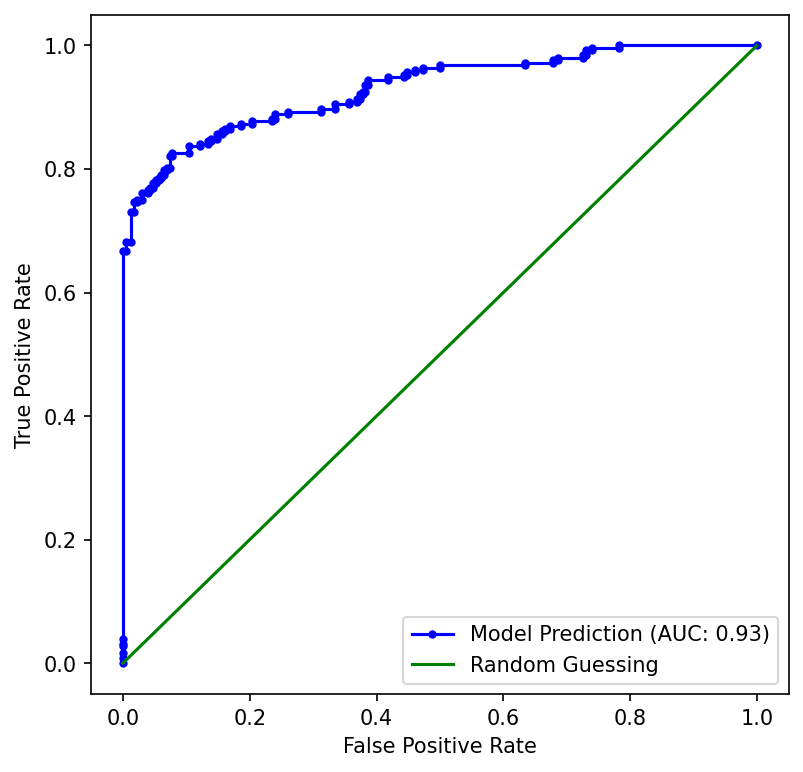

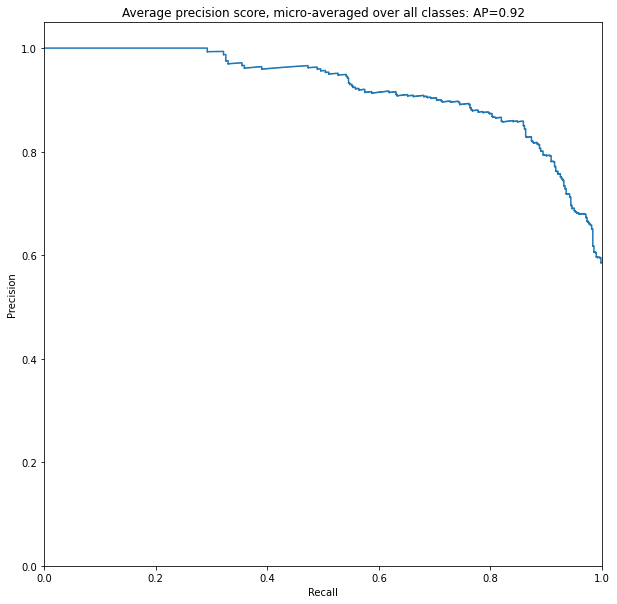

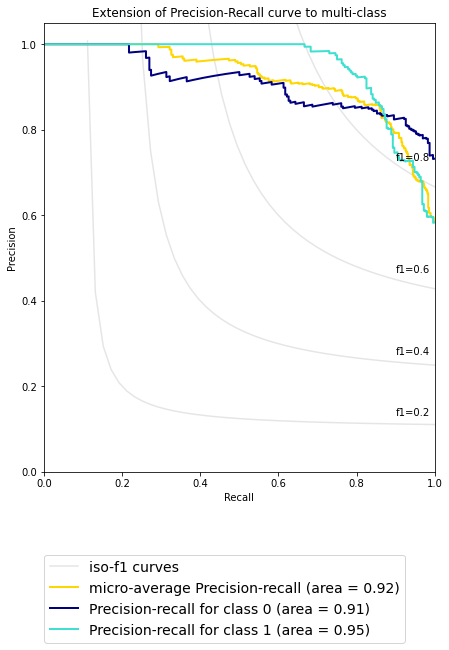

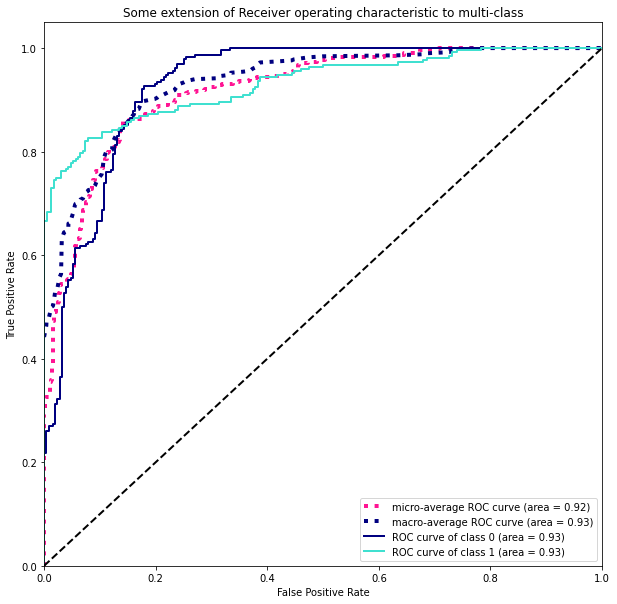

In [15]:
one_hot_labels = to_categorical(test_data.classes).astype('int')[:len(labels)]
plot_results(one_hot_labels, labels, predicted_class_indices, pred)

In [16]:
pred= classifier2.predict(test_data, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = test_data.classes[0:len(predicted_class_indices)]
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))

31/31 [==============================] - 5s 146ms/step
Accuracy on Test Data: 0.80%
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       230
           1       0.83      0.78      0.80       252

    accuracy                           0.80       482
   macro avg       0.80      0.80      0.80       482
weighted avg       0.80      0.80      0.80       482



Average precision score, micro-averaged over all classes: 0.90







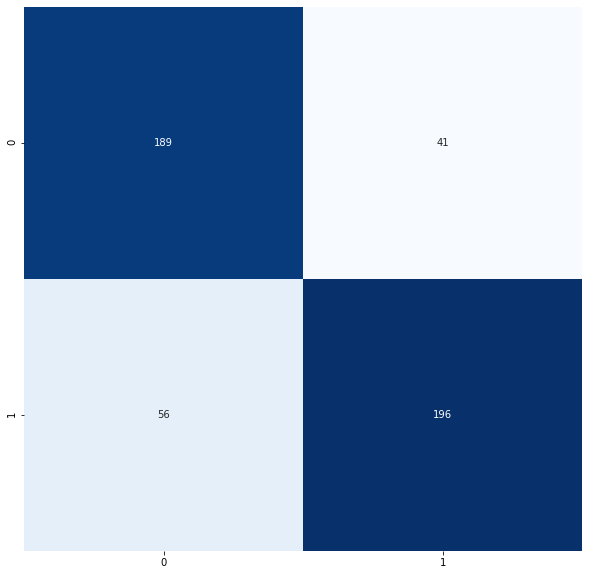

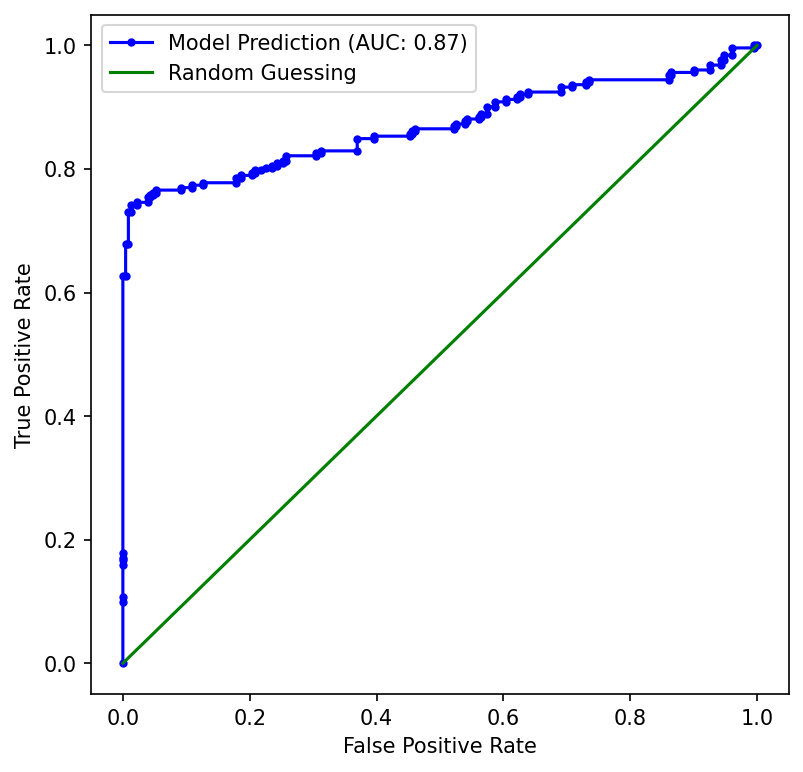

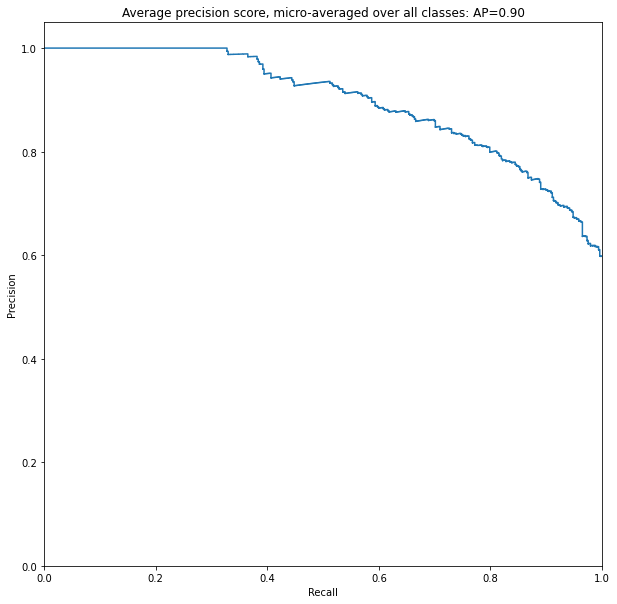

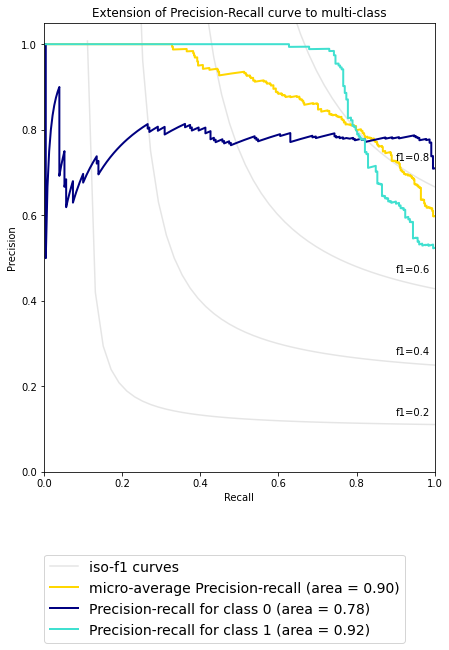

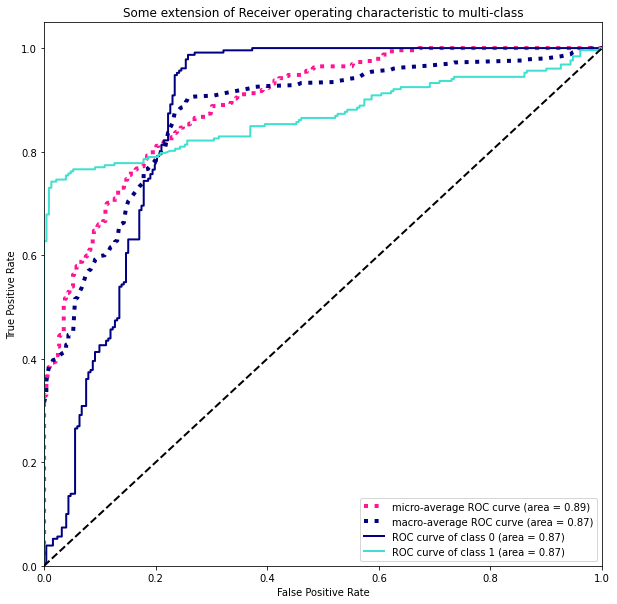

In [17]:
one_hot_labels = to_categorical(test_data.classes).astype('int')[:len(labels)]
plot_results(one_hot_labels, labels, predicted_class_indices, pred)

# Test Classifiers on Generated images

1/1 [==============================] - 30s 30s/step


(256, 256, 3)

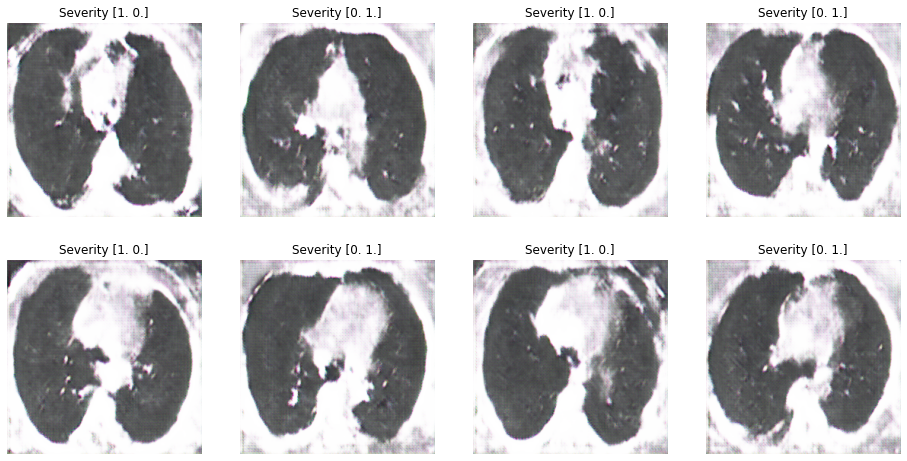

In [10]:
noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
noise_label = np.eye(num_labels)[np.arange(0, 16) % num_labels]
noise_inputs = [noise_input, noise_label]


t_x, t_y = generator.predict(noise_inputs, verbose=1), noise_label
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
      c_ax.imshow(np.clip(c_x * 255, 0, 255).astype('int'))
      c_ax.set_title('Severity {}'.format(c_y))
      c_ax.axis('off')

t_x.shape[1:]

In [18]:
num_data = 750
rs = np.random.RandomState(9)
noise_input1 = rs.uniform(-1.0, 1.0, size=[num_data, latent_size])
noise_label1 = np.eye(num_labels)[np.arange(0, num_data) % num_labels]
noise_inputs = [noise_input1, noise_label1]
images = generator.predict(noise_inputs, verbose=1)
labels =  np.argmax(noise_label1, axis = 1)
pred = classifier1.predict(images, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))

24/24 [==============================] - 9s 288ms/step
Accuracy on Test Data: 0.71%
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       375
           1       0.69      0.77      0.73       375

    accuracy                           0.71       750
   macro avg       0.72      0.71      0.71       750
weighted avg       0.72      0.71      0.71       750



Average precision score, micro-averaged over all classes: 0.78







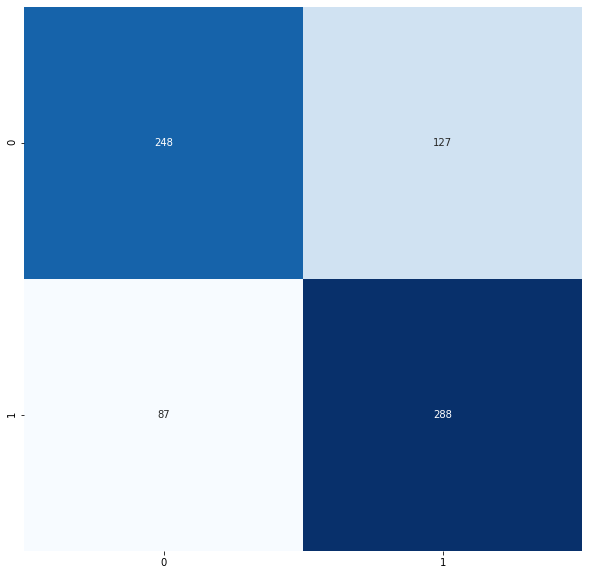

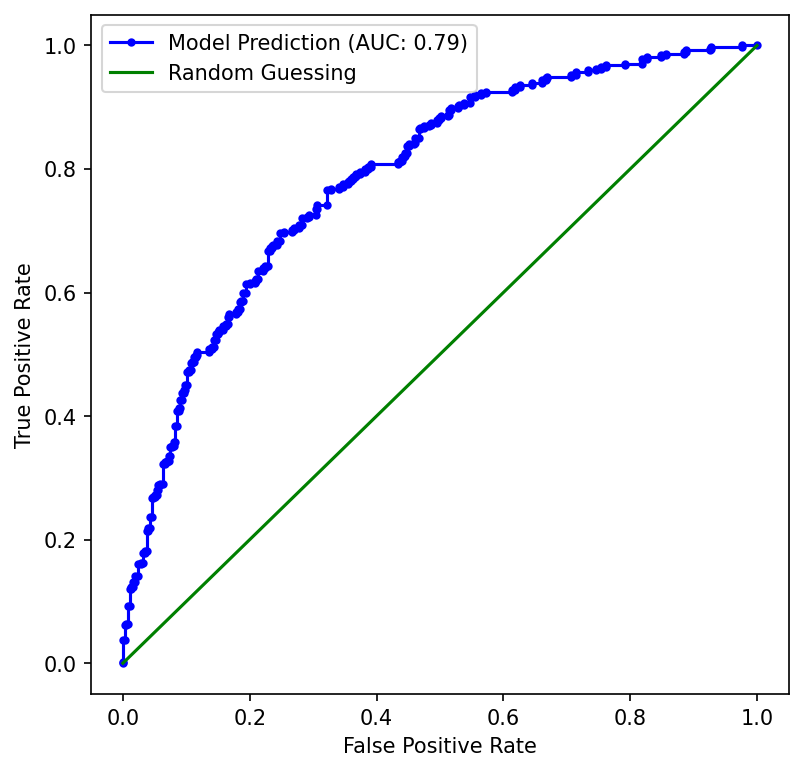

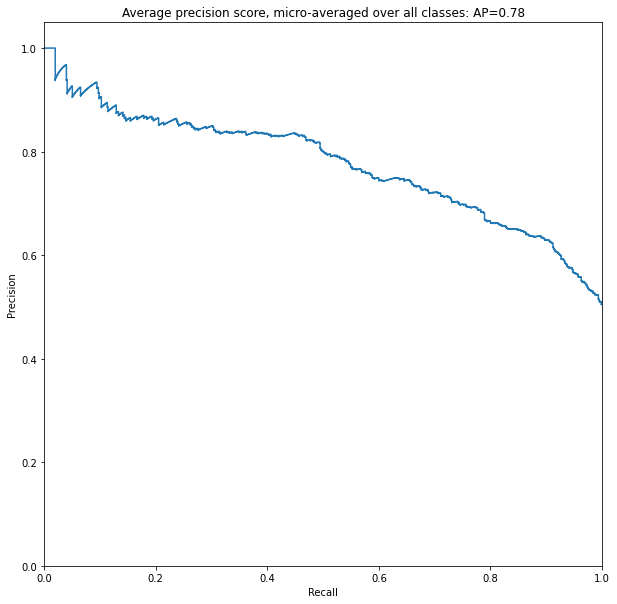

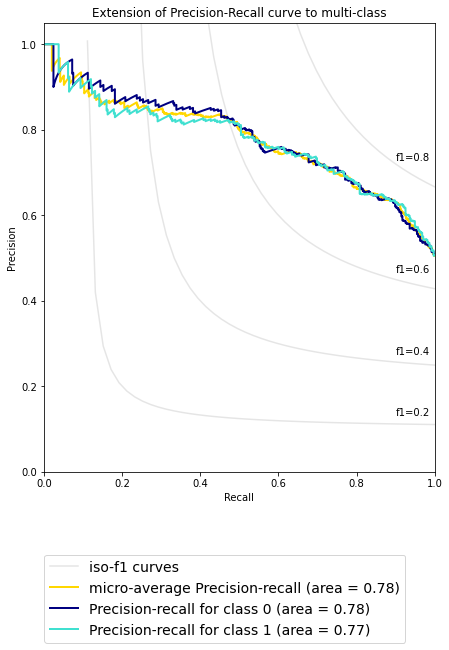

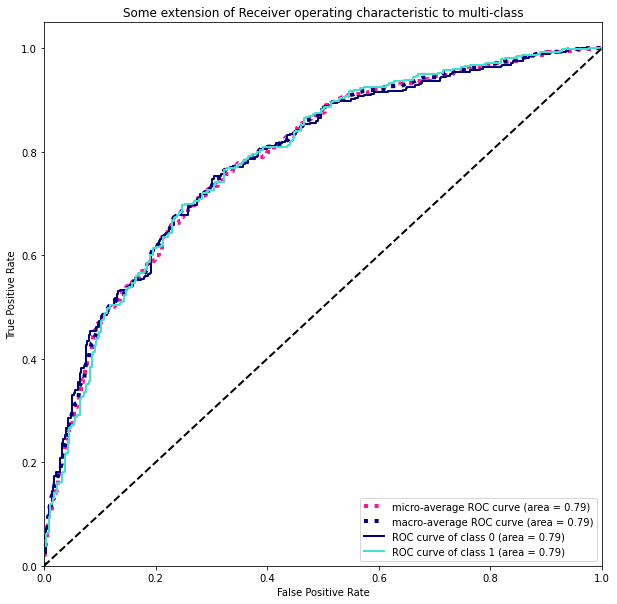

In [19]:
one_hot_labels = noise_label1
plot_results(one_hot_labels, labels, predicted_class_indices, pred)

In [20]:
num_data = 750
rs = np.random.RandomState(9)
noise_input1 = rs.uniform(-1.0, 1.0, size=[num_data, latent_size])
noise_label1 = np.eye(num_labels)[np.arange(0, num_data) % num_labels]
noise_inputs = [noise_input1, noise_label1]
images = generator.predict(noise_inputs, verbose=1)
labels =  np.argmax(noise_label1, axis = 1)
pred = classifier2.predict(images, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))

24/24 [==============================] - 7s 249ms/step
Accuracy on Test Data: 0.79%
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       375
           1       0.79      0.79      0.79       375

    accuracy                           0.79       750
   macro avg       0.79      0.79      0.79       750
weighted avg       0.79      0.79      0.79       750



Average precision score, micro-averaged over all classes: 0.88







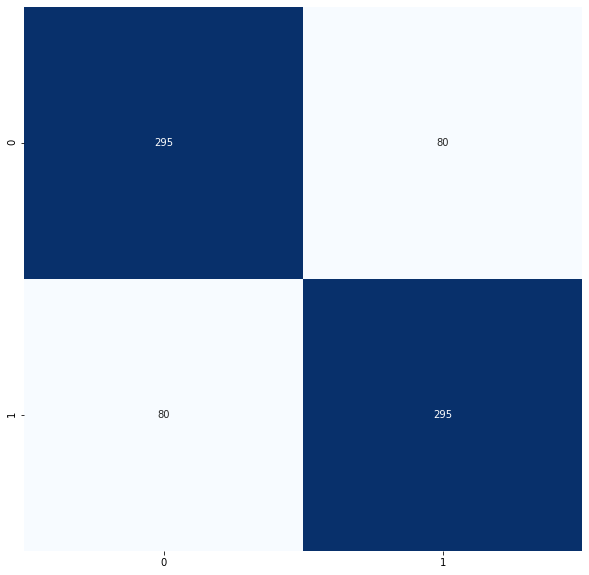

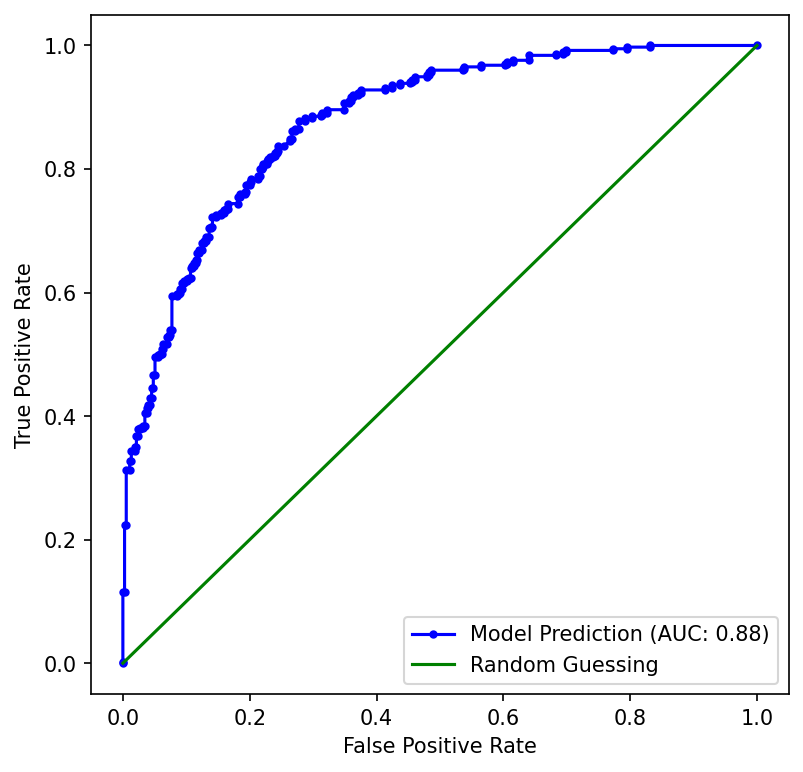

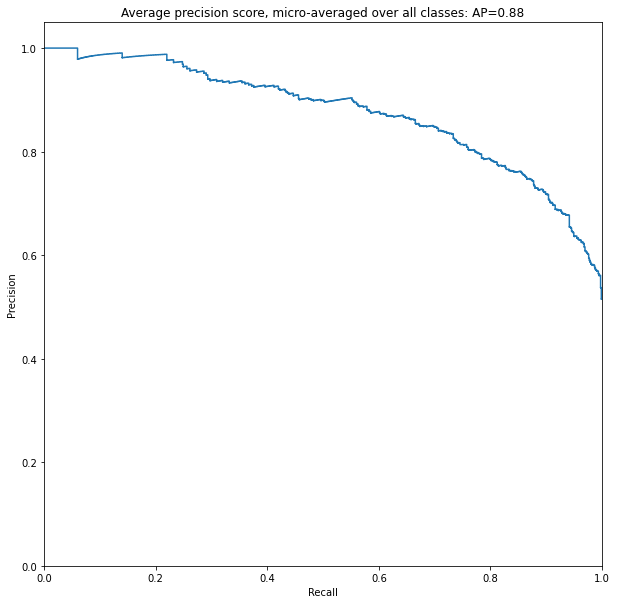

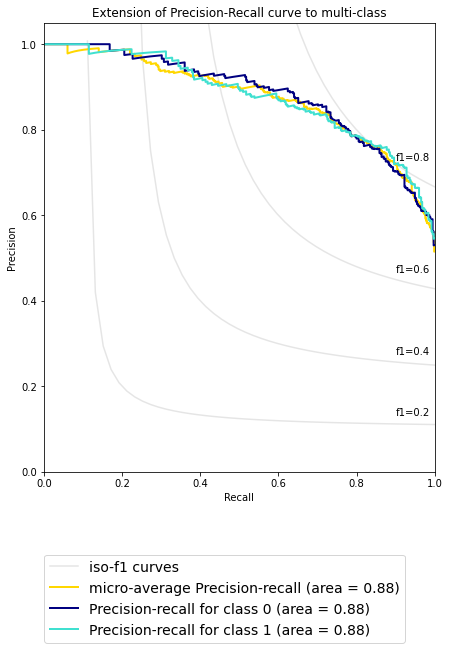

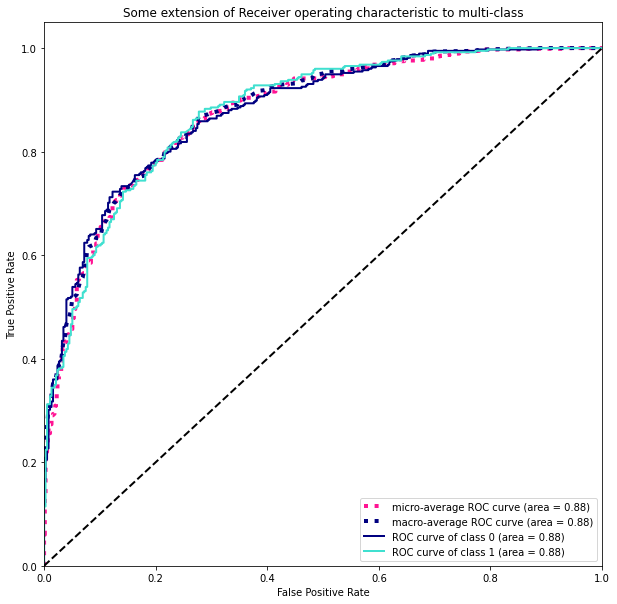

In [21]:
one_hot_labels = noise_label1
plot_results(one_hot_labels, labels, predicted_class_indices, pred)

# Test Classifiers on Real and Fake images

In [22]:
num_data = 750
rs = np.random.RandomState(9)
noise_input1 = rs.uniform(-1.0, 1.0, size=[num_data, latent_size])
noise_label1 = np.eye(num_labels)[np.arange(0, num_data) % num_labels]
noise_inputs = [noise_input1, noise_label1]
images = generator.predict(noise_inputs, verbose=1)
labels =  np.argmax(noise_label1, axis = 1)
pred = classifier1.predict(images, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)




pred1 = classifier1.predict(test_data, verbose=1)
predicted_class_indices1 = np.argmax(pred1,axis=1)
labels1 = test_data.classes[0:len(predicted_class_indices1)]
all_pred = np.concatenate((pred, pred1), axis=0)
all_predicted_class_indices = np.concatenate((predicted_class_indices, predicted_class_indices1), axis=0)
all_labels = np.concatenate((labels, labels1), axis=0)


print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(all_labels, all_predicted_class_indices)))
print(classification_report(all_labels, all_predicted_class_indices))

31/31 [==============================] - 4s 145ms/step
Accuracy on Test Data: 0.77%
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       605
           1       0.78      0.76      0.77       627

    accuracy                           0.77      1232
   macro avg       0.77      0.77      0.77      1232
weighted avg       0.77      0.77      0.77      1232



Average precision score, micro-averaged over all classes: 0.85







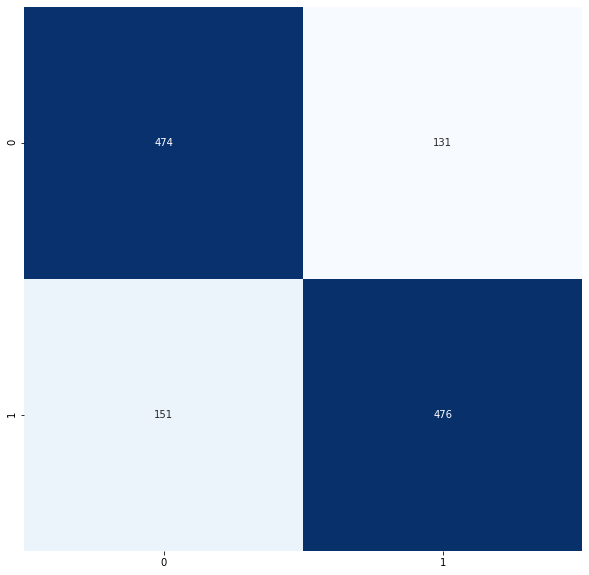

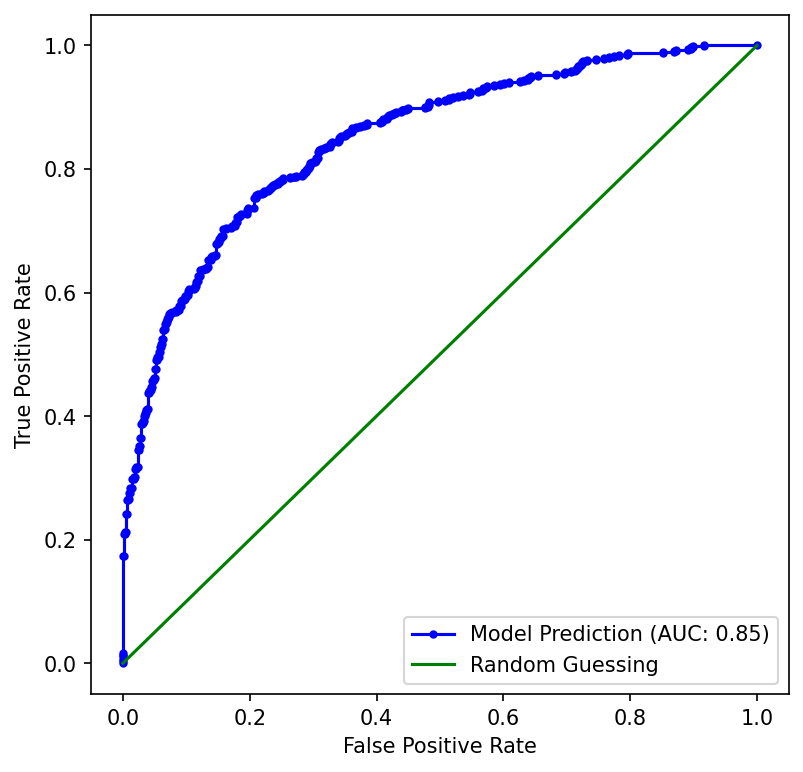

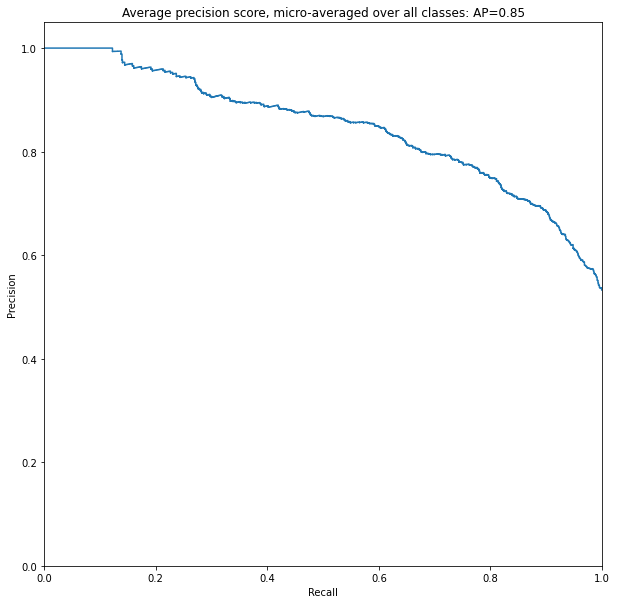

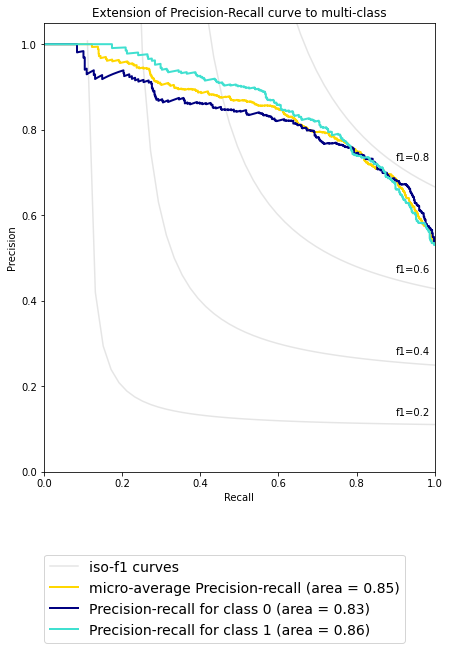

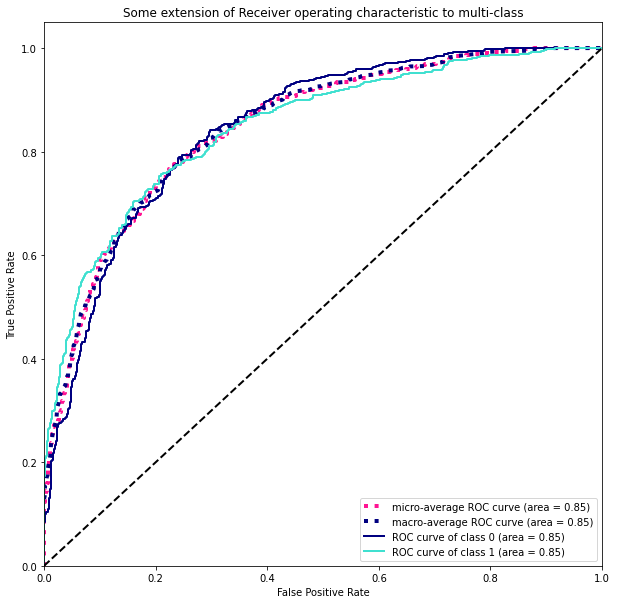

In [31]:
one_hot_labels = to_categorical(all_labels)
plot_results(one_hot_labels, all_labels, all_predicted_class_indices, all_pred)

In [32]:
num_data = 750
rs = np.random.RandomState(9)
noise_input1 = rs.uniform(-1.0, 1.0, size=[num_data, latent_size])
noise_label1 = np.eye(num_labels)[np.arange(0, num_data) % num_labels]
noise_inputs = [noise_input1, noise_label1]
images = generator.predict(noise_inputs, verbose=1)
labels =  np.argmax(noise_label1, axis = 1)
pred = classifier2.predict(images, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)




pred1 = classifier1.predict(test_data, verbose=1)
predicted_class_indices2 = np.argmax(pred1,axis=1)
labels1 = test_data.classes[0:len(predicted_class_indices1)]
all_pred = np.concatenate((pred, pred1), axis=0)
all_predicted_class_indices = np.concatenate((predicted_class_indices, predicted_class_indices1), axis=0)
all_labels = np.concatenate((labels, labels1), axis=0)


print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(all_labels, all_predicted_class_indices)))
print(classification_report(all_labels, all_predicted_class_indices))

31/31 [==============================] - 4s 143ms/step
Accuracy on Test Data: 0.81%
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       605
           1       0.85      0.77      0.81       627

    accuracy                           0.81      1232
   macro avg       0.82      0.82      0.81      1232
weighted avg       0.82      0.81      0.81      1232



Average precision score, micro-averaged over all classes: 0.89







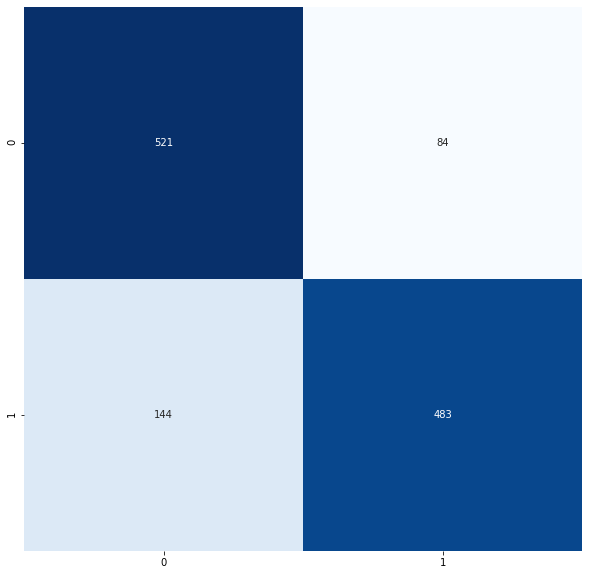

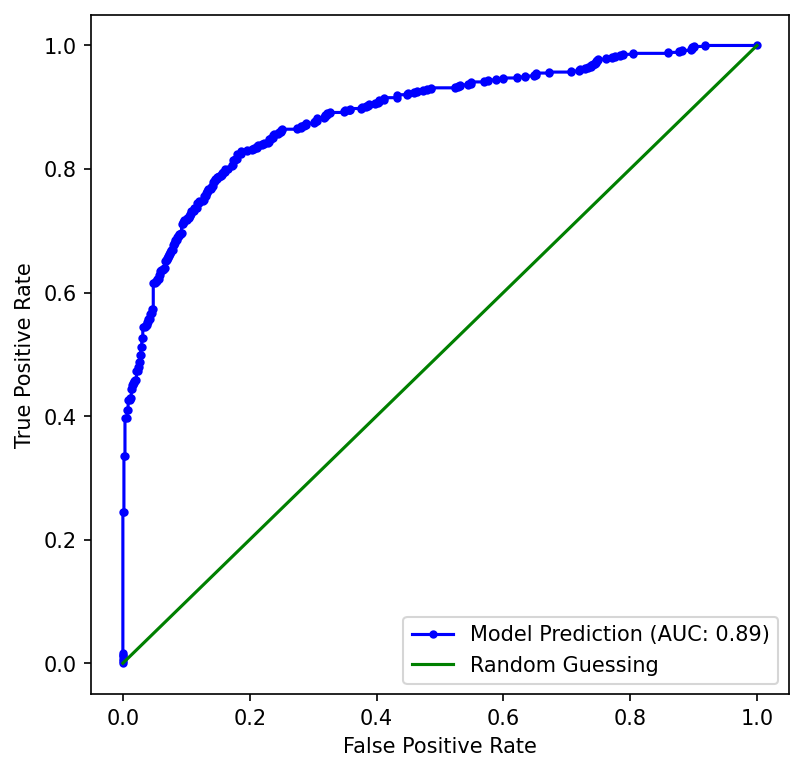

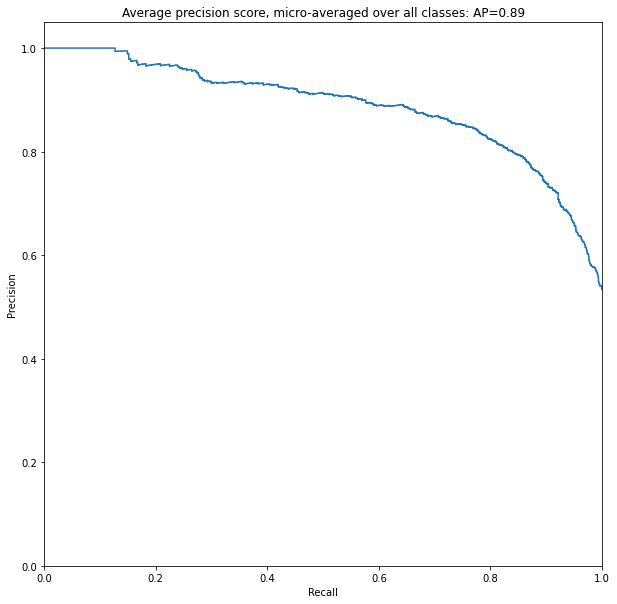

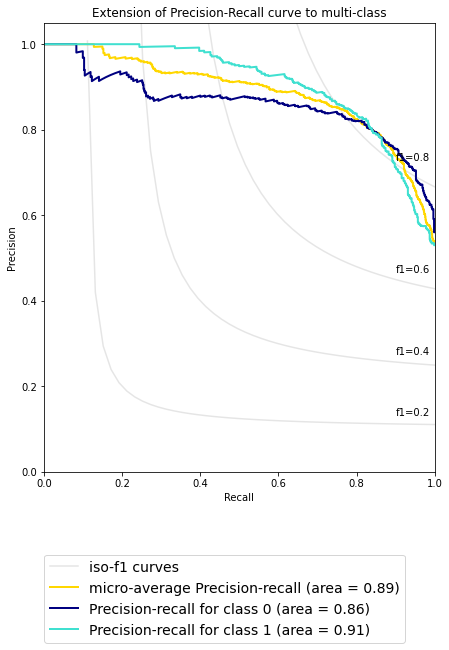

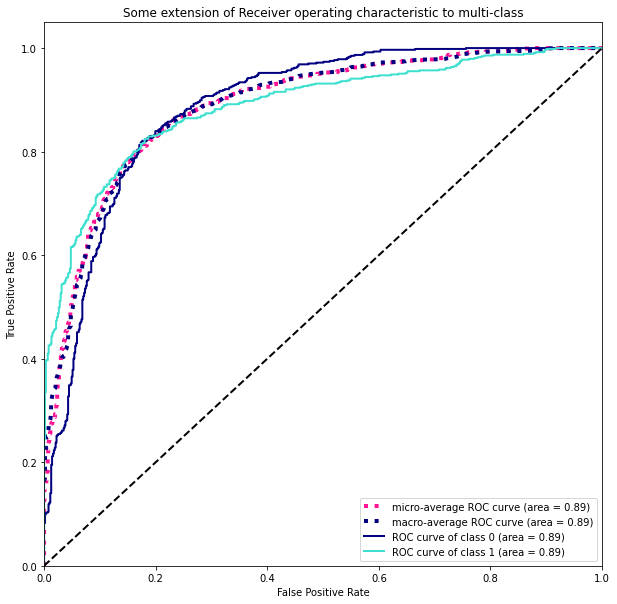

In [33]:
one_hot_labels = to_categorical(all_labels)
plot_results(one_hot_labels, all_labels, all_predicted_class_indices, all_pred)